In [1]:
import sys

sys.path.append('../')

In [2]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [3]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.vocab import *
from mrl.callbacks import *
from mrl.callbacks.template_cb import *
from mrl.agent import *
from mrl.policy_gradient import *
from mrl.loss import *
from mrl.sampler import *
from mrl.environment import *
from mrl.reward import *

In [4]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(1)
set_global_pool(cpus=8)

## Reward Function

In [5]:
df = pd.read_csv('../nbs/untracked_files/affinity_data.csv')
df = df[df.smiles.map(lambda x: not '.' in x)]

In [6]:
reward_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])
r_ds = Vec_Prediction_Dataset(df.smiles.values, df.value.values/10, ECFP6)
r_agent = PredictiveAgent(reward_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

In [7]:
r_agent.train_supervised(32, 12, 1e-3, percent_valid=0.1)

Epoch,Train Loss,Valid Loss,Time
0,0.17009,0.15867,00:08
1,0.13449,0.13572,00:07
2,0.04716,0.04434,00:07
3,0.09222,0.05951,00:07
4,0.06012,0.03653,00:07
5,0.04333,0.02593,00:07
6,0.05999,0.02924,00:07
7,0.02261,0.02106,00:07
8,0.02450,0.02146,00:07
9,0.03441,0.03295,00:07


In [8]:
r_agent.save_weights('../nbs/untracked_files/affinity_mlp.pt')

In [9]:
# validate

_, valid_ds = r_ds.split(0.1)

valid_dl = valid_ds.dataloader(256, num_workers=0, shuffle=False)
r_agent.model.eval();

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(valid_dl):
        batch = to_device(batch)
        x,y = batch
        pred = r_agent.model(x)
        preds.append(pred.detach().cpu())
        targs.append(y.detach().cpu())
        
preds = torch.cat(preds).numpy()
targs = torch.cat(targs).numpy()

Text(0.9, 0.2, 'R-squared = 0.85')

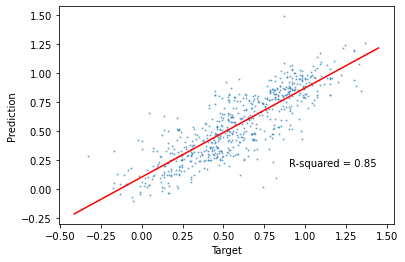

In [10]:
fig, ax = plt.subplots()

ax.scatter(targs, preds, alpha=0.5, s=1)
plt.xlabel('Target')
plt.ylabel('Prediction')

slope, intercept = np.polyfit(targs, preds, 1)
ax.plot(np.array(ax.get_xlim()), intercept + slope*np.array(ax.get_xlim()), c='r')

ybar = targs.sum()/len(targs)
ssreg = ((preds-ybar)**2).sum()
sstot = ((targs-ybar)**2).sum()
r_sq = ssreg/sstot
plt.text(0.9, 0.2, 'R-squared = %0.2f' % r_sq)

## Generative RL

In [5]:
# def scale_sa(sa):
#     return (10-sa)/9

# template = Template([ValidityFilter(), 
#                      SingleCompoundFilter(), 
#                      RotBondFilter(None, 8),
#                      ChargeFilter(None, 0)],
#                     [QEDFilter(0.5, None, score=1.),
#                      SAFilter(None, 6, score=1.)], 
#                     fail_score=-10., log=False)

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 8),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

template_cb = TemplateCallback(template, prefilter=True)

In [6]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [7]:
r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/affinity_mlp.pt')

r_model.eval();

freeze(r_model)

reward = Reward(r_agent.predict_data, weight=-10.)

aff_reward = RewardCallback(reward, 'aff')


# aff_reward = FunctionReward(r_agent.predict_data, 
#                             'aff', 
#                             weight=-10.)

In [8]:
aff_reward.reward(['CCC'])

tensor(-9.0583, device='cuda:1')

In [9]:
temp_df = pd.read_csv('template_filtered.csv')
temp_df.shape

(4206402, 1)

### FP VAE

In [9]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = VAELoss(weight=0.5)

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
        )

model.z_scale = 0.1

model.load_state_dict(torch.load('../nbs/untracked_files/fp_vae_zinc.pt'))

<All keys matched successfully>

In [10]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [11]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [12]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [13]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [13]:
env.fit(200, 90, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-8.538,-8.538,1.000,1.000,132,0.000,0.660,1.000,0.433,-8.539,1.000,-8.538,0.237,-7.264,-6.056
10,-8.483,-8.483,1.000,1.000,138,0.000,0.690,1.000,0.483,-8.485,1.000,-8.483,0.218,-7.124,-5.858
20,-8.198,-8.198,0.947,1.000,132,0.000,0.660,1.000,0.433,-8.221,1.000,-8.198,0.331,-6.903,-4.399
30,-8.227,-8.227,0.954,1.000,130,0.000,0.650,1.000,0.417,-8.308,1.000,-8.227,0.297,-6.995,-5.432
40,-8.227,-8.227,0.950,1.000,139,0.000,0.695,1.000,0.492,-8.115,1.000,-8.227,0.333,-6.338,-4.420
50,-8.289,-8.289,0.951,1.000,123,0.000,0.615,1.000,0.358,-8.347,1.000,-8.289,0.301,-6.606,-5.845
60,-8.314,-8.314,0.934,1.000,122,0.000,0.610,1.000,0.350,-8.631,1.000,-8.314,0.440,-7.057,-5.714
70,-8.316,-8.316,0.940,1.000,133,0.000,0.665,1.000,0.442,-8.534,1.000,-8.316,0.400,-7.226,-6.003
80,-8.227,-8.227,0.945,1.000,128,0.000,0.640,1.000,0.400,-8.360,1.000,-8.227,0.291,-7.150,-5.788
90,-8.115,-8.115,0.921,1.000,126,0.000,0.630,1.000,0.383,-8.287,1.000,-8.115,0.263,-7.220,-6.285


Epoch,Train Loss,Valid Loss,Time
0,0.33343,0.34636,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.33081,0.33688,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.34126,0.32213,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.32627,0.35126,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.29297,0.29223,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.29448,0.29296,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.32784,0.31985,00:09


Epoch,Train Loss,Valid Loss,Time
0,8.84455,6.73361,00:10


Epoch,Train Loss,Valid Loss,Time
0,2.66713,1.54351,00:12


Epoch,Train Loss,Valid Loss,Time
0,1.37297,0.84910,00:13


In [16]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)

avg_reward = np.array(env.log.metrics['rewards'][-20:]).mean()
subset = log_df[(log_df.rewards>avg_reward) & (log_df.template>-5)]
print(subset.shape)

agent.model.load_state_dict(torch.load('../nbs/untracked_files/fp_vae_zinc.pt'))

agent.update_dataset_from_inputs(subset.samples.values)

agent.train_supervised(128, 3, 5e-5)

agent.base_model.load_state_dict(agent.model.state_dict())

(13237, 7)


Epoch,Train Loss,Valid Loss,Time
0,0.20996,0.22560,00:21
1,0.17573,0.20006,00:21
2,0.18041,0.19760,00:21


<All keys matched successfully>

In [17]:
env.fit(200, 90, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
2000,-3.952,-3.952,0.587,0.994,179,0.000,0.895,1.000,0.825,-4.005,0.616,-3.952,1.280,-1.140,-0.293
2010,-4.215,-4.215,0.673,1.000,168,0.000,0.840,1.000,0.733,-4.185,0.625,-4.215,1.293,-1.106,-0.450
2020,-3.820,-3.820,0.588,0.994,170,0.000,0.850,1.000,0.750,-3.695,0.600,-3.820,0.937,-1.454,-0.293
2030,-4.020,-4.020,0.522,1.000,161,0.000,0.805,1.000,0.675,-4.092,0.494,-4.020,1.000,-1.393,-0.450
2040,-4.113,-4.113,0.555,0.994,173,0.000,0.865,1.000,0.775,-4.008,0.516,-4.113,0.904,-1.364,-0.491
2050,-3.606,-3.606,0.525,1.000,181,0.000,0.905,1.000,0.842,-3.437,0.465,-3.606,0.779,-1.245,-0.655
2060,-3.369,-3.369,0.483,0.994,178,0.000,0.890,0.990,0.817,-3.019,0.398,-3.369,0.797,-1.155,-0.474
2070,-3.610,-3.610,0.428,0.988,173,0.000,0.865,0.989,0.775,-3.495,0.430,-3.610,0.743,-1.333,-0.657
2080,-3.835,-3.835,0.466,1.000,178,0.000,0.890,1.000,0.817,-3.945,0.469,-3.835,0.764,-1.320,-0.098
2090,-3.482,-3.482,0.421,0.994,171,0.000,0.855,0.989,0.758,-3.504,0.418,-3.482,0.668,-1.255,-0.327


Epoch,Train Loss,Valid Loss,Time
0,0.15435,0.16270,00:13


Epoch,Train Loss,Valid Loss,Time
0,0.15317,0.14812,00:15


Epoch,Train Loss,Valid Loss,Time
0,0.14686,0.14061,00:15


Epoch,Train Loss,Valid Loss,Time
0,0.13945,0.13165,00:16


Epoch,Train Loss,Valid Loss,Time
0,0.13533,0.13963,00:17


Epoch,Train Loss,Valid Loss,Time
0,0.15701,0.13439,00:17


Epoch,Train Loss,Valid Loss,Time
0,0.13848,0.13411,00:18


Epoch,Train Loss,Valid Loss,Time
0,0.12511,0.12360,00:18


Epoch,Train Loss,Valid Loss,Time
0,0.13402,0.12984,00:19


Epoch,Train Loss,Valid Loss,Time
0,0.13381,0.12445,00:19


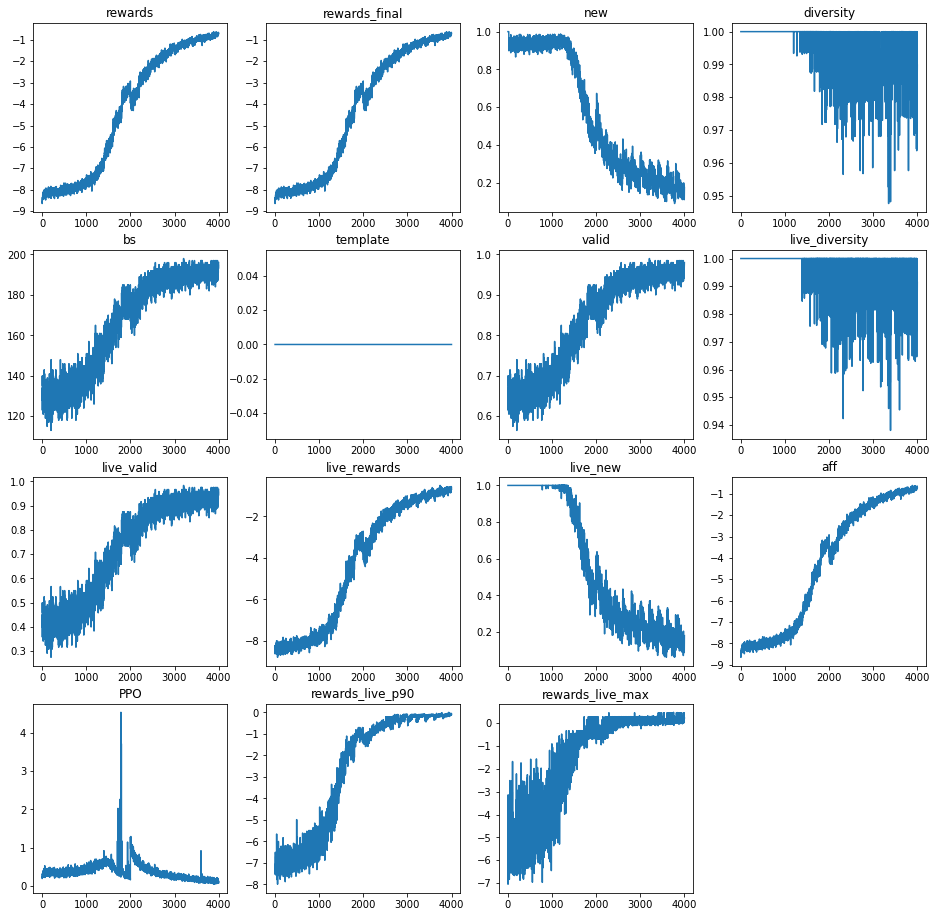

In [18]:
env.log.plot_metrics()

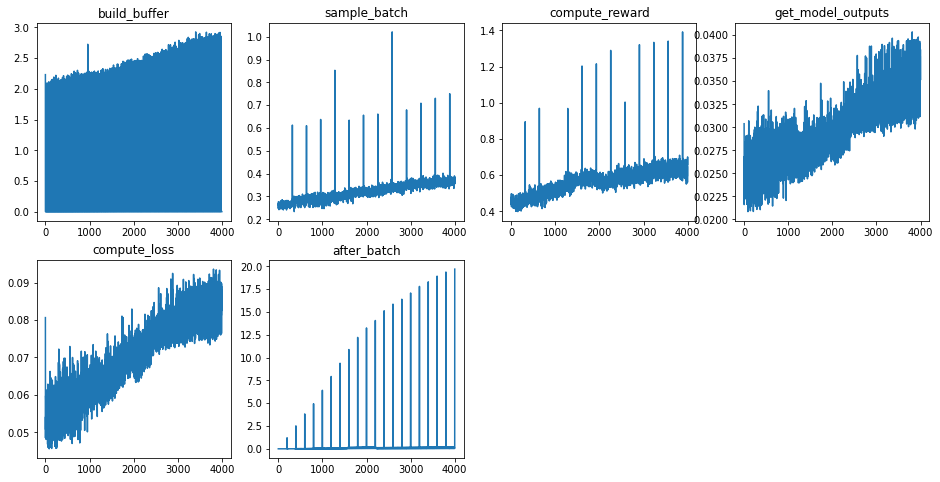

In [19]:
env.log.plot_timelog()

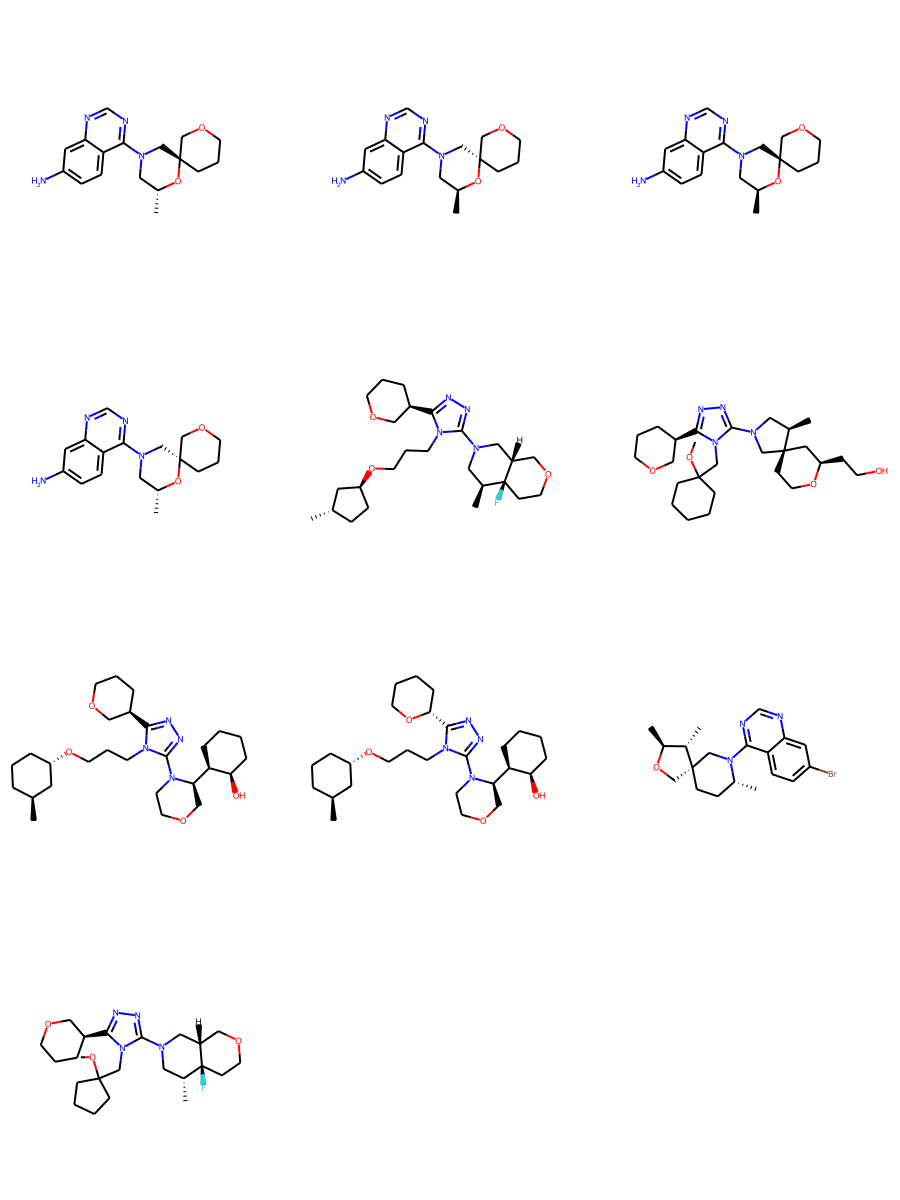

In [23]:
draw_mols(to_mols(env.log.df[env.log.df.aff>0.4].samples.values))

### LSTM LM

In [9]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

<All keys matched successfully>

In [10]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [11]:
agent.update_dataset_from_inputs(temp_df.smiles.values[:1000000])

In [12]:
agent.train_supervised(800, 1, 1e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.30351,0.31053,04:25


In [13]:
torch.cuda.empty_cache()

In [14]:
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

In [11]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [12]:
class LRCallback(Callback):
    def __init__(self, agent):
        super().__init__(name='lr')
        self.agent = agent
        
    def setup(self):
        log = self.environment.log
        log.add_metric(f'{self.name}')
        
    def after_batch(self):
        log = self.environment.log
        log.update_metric('lr', f"{self.agent.opt.param_groups[0]['lr']:.2e}")

In [13]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)
# new_cb = NoveltyReward(weight=0.05)
# lr_cb = LRCallback(agent)

cbs = [supervised_cb, live_p90, live_max]

In [14]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [15]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-8.525,-8.525,1.000,1.000,130,0.000,0.650,1.000,0.417,-8.609,1.000,-8.525,0.206,-7.331,-6.474
10,-8.173,-8.173,1.000,1.000,128,0.000,0.640,1.000,0.400,-8.325,1.000,-8.173,0.239,-7.069,-6.434
20,-8.245,-8.245,0.937,1.000,126,0.000,0.630,1.000,0.383,-8.521,1.000,-8.245,0.283,-7.382,-5.678
30,-8.198,-8.198,0.916,1.000,119,0.000,0.595,1.000,0.325,-8.104,1.000,-8.198,0.275,-6.944,-6.659
40,-8.126,-8.126,0.901,1.000,121,0.000,0.605,1.000,0.342,-8.435,1.000,-8.126,0.278,-7.241,-6.652
50,-8.276,-8.276,0.936,1.000,125,0.000,0.625,1.000,0.375,-8.239,1.000,-8.276,0.365,-6.762,-3.643
60,-8.071,-8.071,0.901,1.000,121,0.000,0.605,1.000,0.342,-8.053,1.000,-8.071,0.325,-6.741,-5.320
70,-7.890,-7.890,0.878,1.000,115,0.000,0.575,1.000,0.292,-8.044,1.000,-7.890,0.374,-6.778,-4.878
80,-8.137,-8.137,0.920,1.000,125,0.000,0.625,1.000,0.375,-8.113,1.000,-8.137,0.363,-6.816,-4.470
90,-8.010,-8.010,0.892,1.000,130,0.000,0.650,1.000,0.417,-8.235,1.000,-8.010,0.357,-6.602,-5.095


Epoch,Train Loss,Valid Loss,Time
0,0.35872,0.35080,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.31075,0.33361,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.28198,0.28854,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.23103,0.22368,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.18153,0.15966,00:01


In [16]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
1000,-4.219,-4.219,0.549,0.994,173,0.000,0.865,0.989,0.775,-3.701,0.495,-4.219,0.681,-1.554,-0.326
1010,-3.606,-3.606,0.524,0.982,166,0.000,0.830,0.977,0.717,-3.334,0.477,-3.606,0.674,-0.977,-0.380
1020,-3.476,-3.476,0.477,0.989,176,0.000,0.880,0.990,0.800,-3.293,0.427,-3.476,0.568,-1.252,-0.326
1030,-3.621,-3.621,0.444,1.000,169,0.000,0.845,1.000,0.742,-3.422,0.416,-3.621,0.465,-1.602,-0.568
1040,-3.951,-3.951,0.440,0.989,175,0.000,0.875,1.000,0.792,-3.644,0.411,-3.951,0.625,-1.252,-0.445
1050,-3.904,-3.904,0.471,0.982,170,0.000,0.850,0.989,0.750,-3.713,0.433,-3.904,0.586,-1.558,-0.380
1060,-3.492,-3.492,0.378,0.976,164,0.000,0.820,0.952,0.700,-3.524,0.393,-3.492,0.492,-1.564,-0.445
1070,-3.481,-3.481,0.482,0.982,166,0.000,0.830,0.977,0.717,-3.123,0.442,-3.481,0.499,-1.438,-0.380
1080,-3.450,-3.450,0.434,0.971,173,0.000,0.865,0.957,0.775,-3.168,0.355,-3.450,0.545,-0.912,-0.380
1090,-3.436,-3.436,0.450,0.982,171,0.000,0.855,0.978,0.758,-3.241,0.374,-3.436,0.499,-0.914,-0.380


Epoch,Train Loss,Valid Loss,Time
0,0.16310,0.16349,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.17223,0.16660,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.16018,0.14408,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.16034,0.14258,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.14698,0.14178,00:02


In [20]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)

avg_reward = np.array(env.log.metrics['rewards'][-20:]).mean()
subset = log_df[(log_df.rewards>avg_reward) & (log_df.template>-5)]
print(subset.shape)

agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

agent.update_dataset_from_inputs(subset.samples.values)

agent.train_supervised(128, 3, 5e-5)

agent.base_model.load_state_dict(agent.model.state_dict())

(4920, 7)


Epoch,Train Loss,Valid Loss,Time
0,0.20334,0.21088,00:01
1,0.16882,0.16676,00:01
2,0.16585,0.16255,00:01


<All keys matched successfully>

In [21]:
env.fit(200, 90, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
2000,-2.595,-2.595,0.390,1.000,159,0.000,0.795,1.000,0.658,-3.605,0.532,-2.595,1.102,-0.869,-0.488
2010,-2.427,-2.427,0.352,1.000,162,0.000,0.810,1.000,0.683,-3.500,0.573,-2.427,0.915,-0.801,-0.460
2020,-3.500,-3.500,0.478,0.994,161,0.000,0.805,1.000,0.675,-3.911,0.568,-3.500,1.446,-0.892,-0.369
2030,-3.118,-3.118,0.427,1.000,164,0.000,0.820,1.000,0.700,-3.286,0.393,-3.118,1.079,-0.823,-0.380
2040,-3.310,-3.310,0.519,0.994,162,0.000,0.810,1.000,0.683,-3.236,0.524,-3.310,1.160,-0.892,-0.315
2050,-3.355,-3.355,0.494,0.994,162,0.000,0.810,0.988,0.683,-3.389,0.402,-3.355,0.966,-1.018,-0.246
2060,-3.484,-3.484,0.506,0.994,158,0.000,0.790,1.000,0.650,-3.284,0.436,-3.484,1.143,-0.892,-0.369
2070,-3.198,-3.198,0.432,0.993,148,0.000,0.740,1.000,0.567,-3.302,0.353,-3.198,1.180,-0.646,-0.369
2080,-3.074,-3.074,0.406,0.994,160,0.000,0.800,1.000,0.667,-3.175,0.400,-3.074,0.955,-0.793,-0.487
2090,-3.329,-3.329,0.425,1.000,167,0.000,0.835,1.000,0.725,-3.445,0.448,-3.329,0.934,-0.892,0.178


Epoch,Train Loss,Valid Loss,Time
0,0.15349,0.14219,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.13016,0.14576,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.12615,0.15018,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.13546,0.13083,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.23587,0.12844,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.11874,0.11600,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.12908,0.11933,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.11537,0.11356,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.11797,0.11608,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.11233,0.11723,00:03


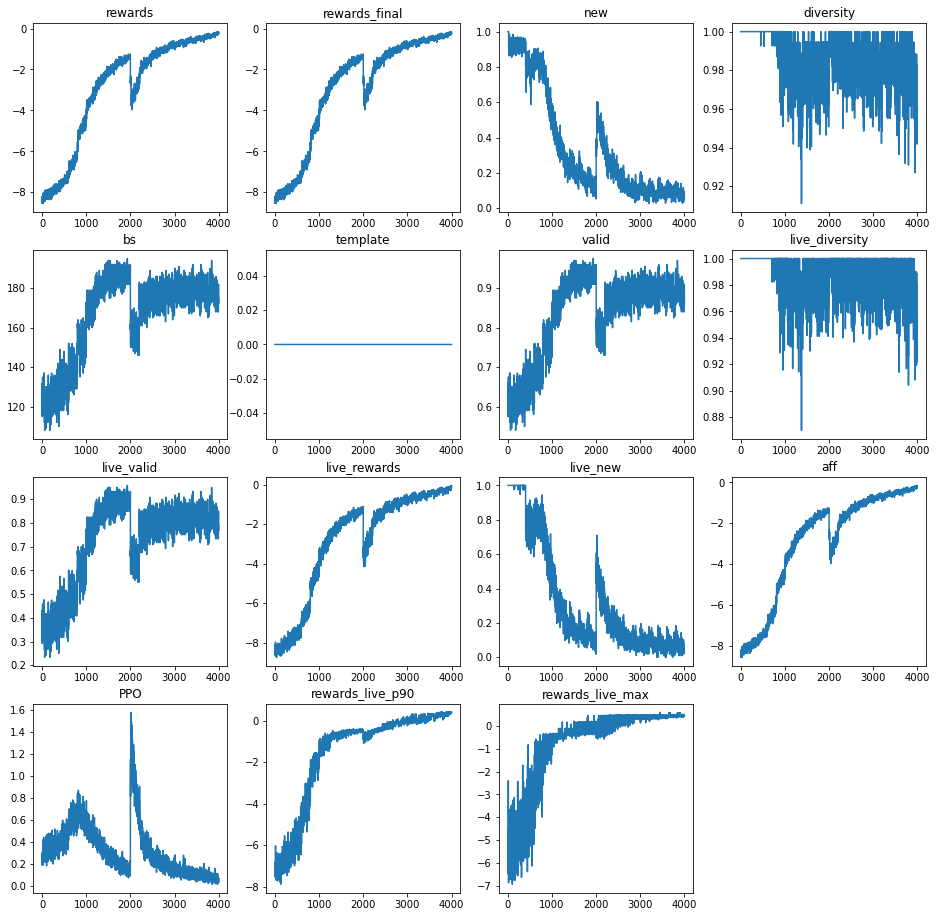

In [22]:
env.log.plot_metrics()

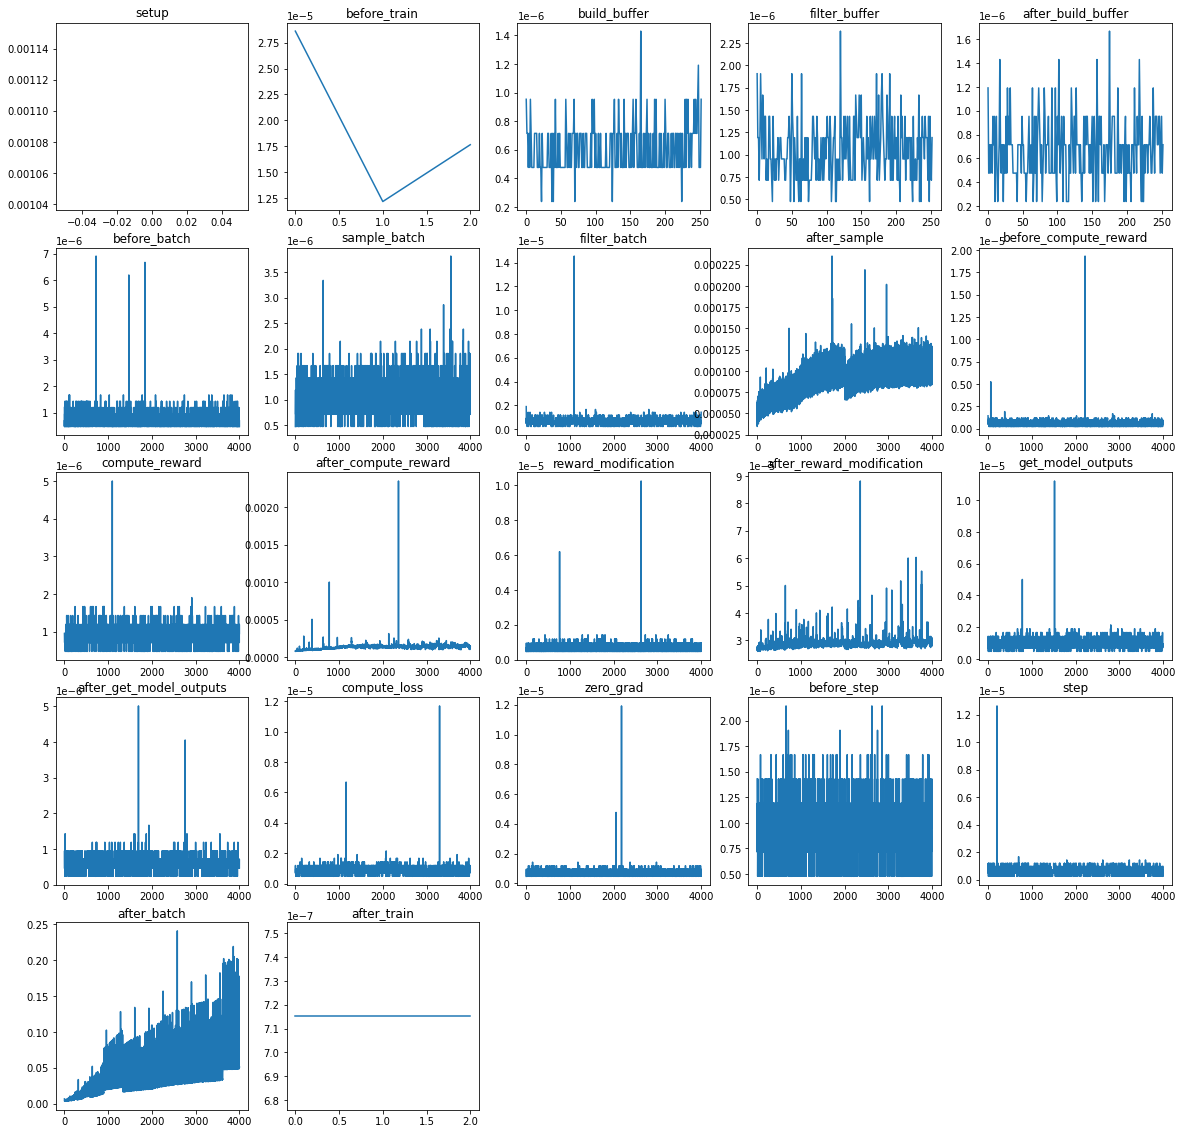

In [24]:
env.log.plot_time(cols=5)

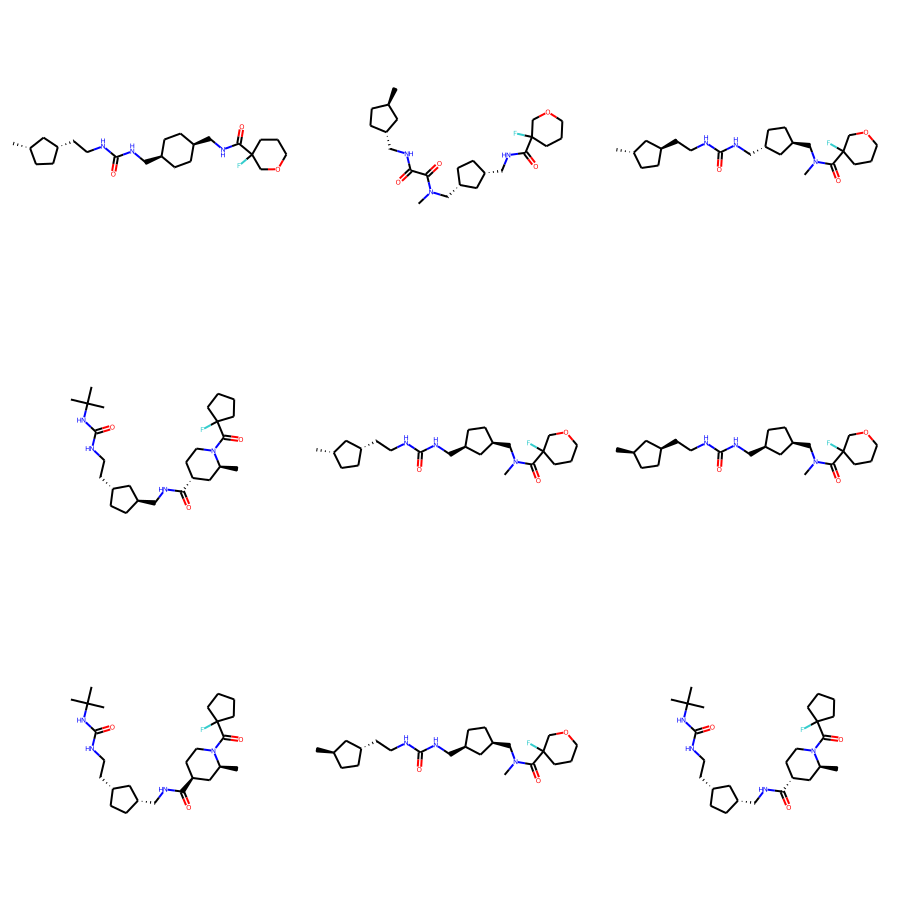

In [33]:
draw_mols(to_mols(env.log.df[env.log.df.aff>0.55].samples.values))

### Conditional LSTM LM Latent Optimization

In [8]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [9]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [10]:
freeze(agent.model)

In [11]:
latents = torch.randn((400, 512))
gen_bs = 1500

sampler = LatentSampler(vocab, agent.model, latents, 'latent', 0, 1., gen_bs, opt_kwargs={'lr':1e-3})

samplers = [sampler]

In [12]:
live_max = MaxCallback('rewards', 'latent')
live_p90 = PercentileCallback('rewards', 'latent', 90)

cbs = [live_p90, live_max]

In [13]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [15]:
env.fit(200, 90, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,latent_diversity,latent_valid,latent_rewards,latent_new,aff,PPO,rewards_latent_p90,rewards_latent_max
0,-8.423,-8.423,1.000,1.000,90,0.000,0.450,1.000,0.450,-8.423,1.000,-8.423,0.156,-7.338,-6.299
10,-8.392,-8.392,0.979,1.000,94,0.000,0.470,1.000,0.470,-8.392,0.979,-8.392,0.201,-7.300,-4.509
20,-8.419,-8.419,0.966,1.000,89,0.000,0.445,1.000,0.445,-8.419,0.966,-8.419,0.237,-6.971,-5.323
30,-8.214,-8.214,0.953,1.000,86,0.000,0.430,1.000,0.430,-8.214,0.953,-8.214,0.223,-6.831,-5.220
40,-8.423,-8.423,0.990,1.000,98,0.000,0.490,1.000,0.490,-8.423,0.990,-8.423,0.175,-7.163,-6.032
50,-8.449,-8.449,0.932,1.000,88,0.000,0.440,1.000,0.440,-8.449,0.932,-8.449,0.252,-7.080,-3.622
60,-8.496,-8.496,0.951,1.000,82,0.000,0.410,1.000,0.410,-8.496,0.951,-8.496,0.177,-7.189,-6.353
70,-8.315,-8.315,0.909,1.000,88,0.000,0.440,1.000,0.440,-8.315,0.909,-8.315,0.271,-6.912,-5.445
80,-8.473,-8.473,0.942,0.988,86,0.000,0.430,0.988,0.430,-8.473,0.942,-8.473,0.211,-7.263,-6.015
90,-8.380,-8.380,0.919,1.000,86,0.000,0.430,1.000,0.430,-8.380,0.919,-8.380,0.214,-7.233,-4.385


In [20]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,latent_diversity,latent_valid,latent_rewards,latent_new,aff,PPO,rewards_latent_p90,rewards_latent_max
2000,-7.082,-7.082,0.481,0.988,81,0.000,0.405,0.988,0.405,-7.082,0.481,-7.082,0.358,-5.484,-3.146
2010,-6.816,-6.816,0.537,1.000,80,0.000,0.400,1.000,0.400,-6.816,0.537,-6.816,0.499,-5.170,-0.413
2020,-6.998,-6.998,0.544,0.987,79,0.000,0.395,0.987,0.395,-6.998,0.544,-6.998,0.295,-5.317,-3.181
2030,-6.800,-6.800,0.512,0.988,82,0.000,0.410,0.988,0.410,-6.800,0.512,-6.800,0.377,-4.878,-3.211
2040,-6.809,-6.809,0.494,0.988,85,0.000,0.425,0.988,0.425,-6.809,0.494,-6.809,0.373,-4.606,-3.669
2050,-6.658,-6.658,0.469,0.975,81,0.000,0.405,0.975,0.405,-6.658,0.469,-6.658,0.387,-4.276,-2.901
2060,-6.737,-6.737,0.545,0.977,88,0.000,0.440,0.977,0.440,-6.737,0.545,-6.737,0.388,-4.849,-2.947
2070,-7.066,-7.066,0.507,0.973,73,0.000,0.365,0.973,0.365,-7.066,0.507,-7.066,0.452,-5.107,-2.198
2080,-7.071,-7.071,0.460,0.966,87,0.000,0.435,0.966,0.435,-7.071,0.460,-7.071,0.314,-5.236,-3.731
2090,-6.904,-6.904,0.500,1.000,100,0.000,0.500,1.000,0.500,-6.904,0.500,-6.904,0.364,-4.910,-2.849


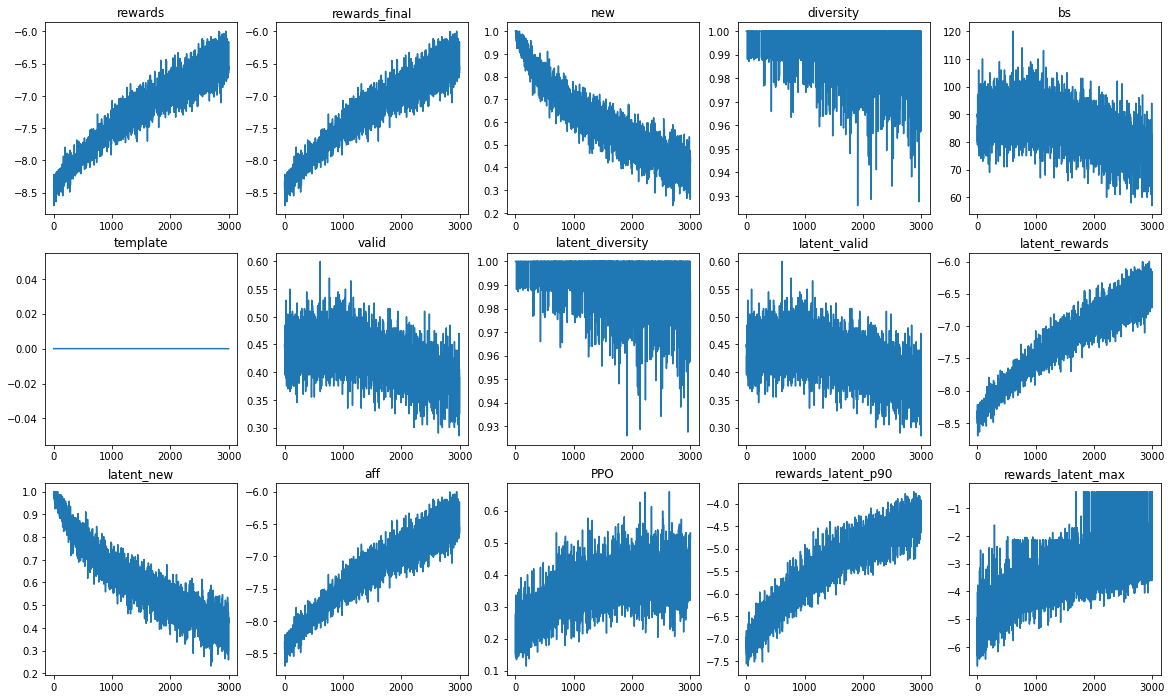

In [21]:
env.log.plot_metrics(cols=5)

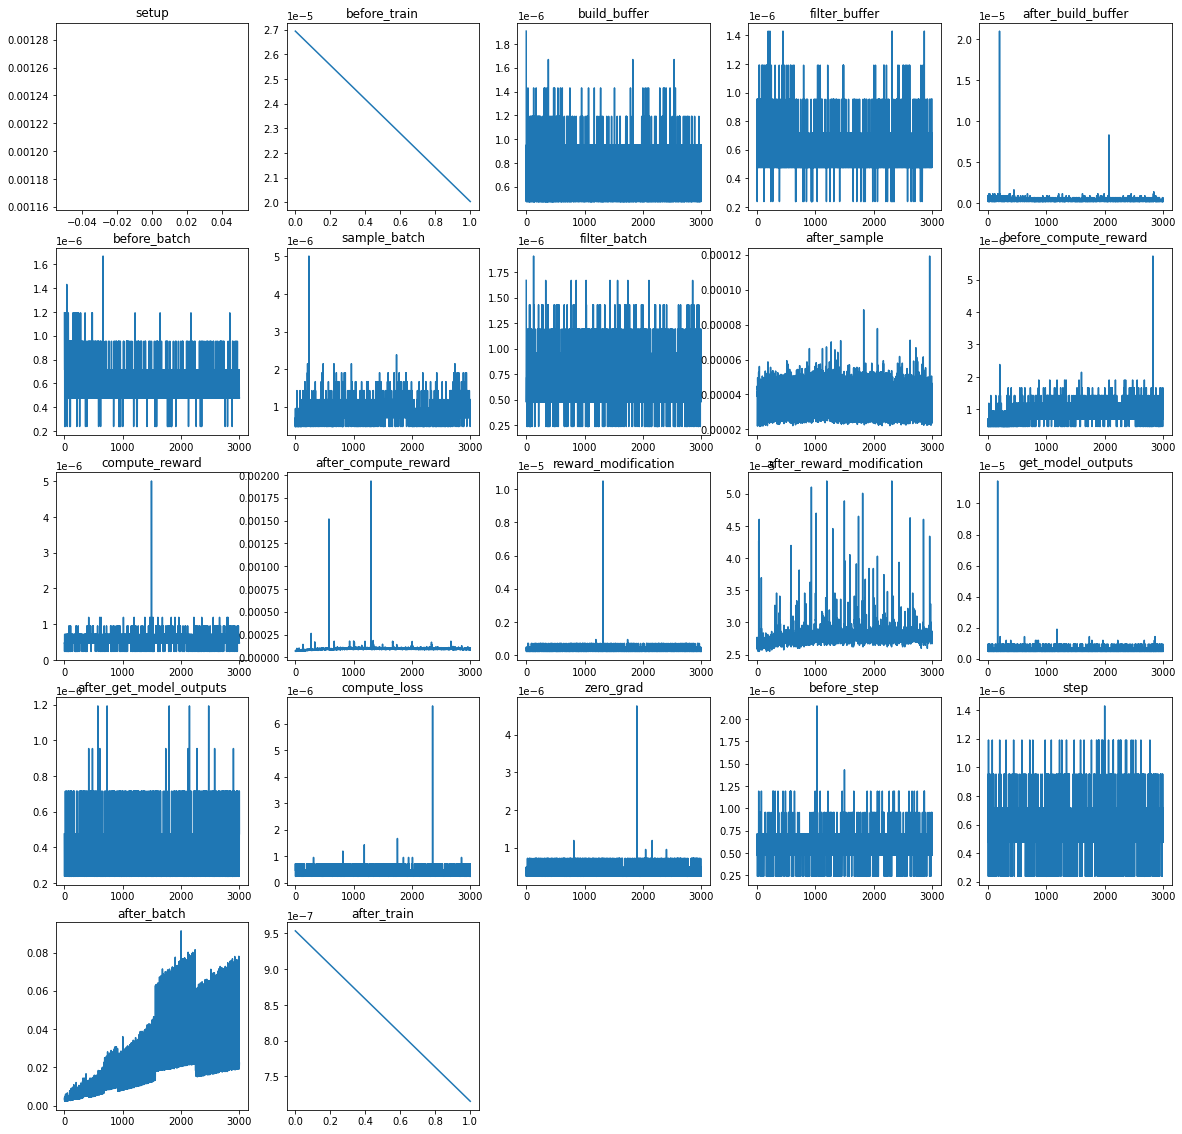

In [22]:
env.log.plot_time(cols=5)

### Conditional LSTM LM Prior Optimization

In [9]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [10]:
ds = ds.new(df[df.value<-2].smiles.values)

In [11]:
x,y = ds.collate_function([ds[i] for i in range(len(ds))])

In [12]:
z = model.x_to_latent(x)

In [13]:
z.mean(0).shape

torch.Size([512])

In [14]:
model.set_prior_from_latent(z[1], torch.zeros((model.encoder.d_latent))-1., trainable=True)

In [15]:
# model.prior = SphericalPrior(torch.zeros((model.encoder.d_latent)), 
#                                 torch.zeros((model.encoder.d_latent)), 
#                                 trainable=True)

In [16]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-3},
                       base_update_iter=5, base_update=.97)

In [17]:
freeze(agent.model.encoder)
freeze(agent.model.decoder)

In [18]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [19]:
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [live_p90, live_max]

In [20]:
pl = PriorLoss(agent.model.prior, agent.model, 
               base_prior=agent.base_model.prior, clip=10.)

prior_loss = LossCallback(pl, 'prior_loss')
his_prior_loss = HistoricPriorLoss(pl, agent.dataset, 97, 200, 10, 2)


In [21]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], 
                  loss_cbs=[prior_loss, his_prior_loss], cbs=cbs)

In [22]:
env.fit(200, 90, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,prior_loss,hist_prior,rewards_live_p90,rewards_live_max
0,-8.410,-8.410,1.000,1.000,143,0.000,0.715,1.000,0.525,-8.637,1.000,-8.410,0.000,0.000,-7.379,-5.189
10,-8.366,-8.366,1.000,1.000,134,0.000,0.670,1.000,0.450,-8.352,1.000,-8.366,-0.047,0.000,-6.963,-5.715
20,-8.128,-8.128,1.000,1.000,147,0.000,0.735,1.000,0.558,-7.838,1.000,-8.128,-0.401,-0.589,-6.470,-4.689
30,-8.033,-8.033,0.942,1.000,138,0.000,0.690,1.000,0.483,-7.890,1.000,-8.033,-0.681,-1.182,-6.478,-4.344
40,-7.752,-7.752,0.954,1.000,130,0.000,0.650,1.000,0.417,-7.506,1.000,-7.752,-0.967,-2.237,-5.739,-1.894
50,-7.501,-7.501,0.928,1.000,138,0.000,0.690,1.000,0.483,-7.352,1.000,-7.501,-1.487,-2.686,-5.909,-5.065
60,-7.586,-7.586,0.942,1.000,139,0.000,0.695,1.000,0.492,-7.455,1.000,-7.586,-1.230,-3.072,-6.094,-4.858
70,-7.365,-7.365,0.910,1.000,134,0.000,0.670,1.000,0.450,-7.261,1.000,-7.365,-1.696,-3.344,-5.194,-3.822
80,-7.417,-7.417,0.957,1.000,138,0.000,0.690,1.000,0.483,-7.221,1.000,-7.417,-2.119,-4.483,-5.289,-3.771
90,-7.183,-7.183,0.932,1.000,132,0.000,0.660,1.000,0.433,-7.156,1.000,-7.183,-1.798,-4.133,-5.402,-3.343


In [35]:
env.fit(200, 90, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,prior_loss,hist_prior,rewards_live_p90,rewards_live_max
2000,-5.070,-5.070,0.593,1.000,140,0.000,0.700,1.000,0.500,-5.080,0.583,-5.070,-4.937,-5.241,-1.849,-0.895
2010,-4.953,-4.953,0.549,1.000,133,0.000,0.665,1.000,0.442,-4.859,0.604,-4.953,-2.709,-1.973,-1.967,-0.713
2020,-4.931,-4.931,0.558,1.000,147,0.000,0.735,1.000,0.558,-5.097,0.522,-4.931,-3.093,-2.841,-2.355,-0.321
2030,-5.171,-5.171,0.693,0.987,150,0.000,0.750,0.986,0.583,-5.145,0.786,-5.171,-4.845,-4.873,-2.244,-0.818
2040,-5.046,-5.046,0.653,1.000,144,0.000,0.720,1.000,0.533,-5.404,0.641,-5.046,-3.594,-4.971,-2.674,-1.572
2050,-4.983,-4.983,0.618,1.000,131,0.000,0.655,1.000,0.425,-5.202,0.647,-4.983,-3.768,-5.346,-2.487,-1.560
2060,-5.204,-5.204,0.587,1.000,143,0.000,0.715,1.000,0.525,-5.309,0.619,-5.204,-3.642,-5.200,-2.540,-0.771
2070,-5.028,-5.028,0.623,0.994,154,0.000,0.770,1.000,0.617,-5.341,0.635,-5.028,-1.790,-2.806,-2.612,-0.771
2080,-4.762,-4.762,0.571,0.993,140,0.000,0.700,1.000,0.500,-5.159,0.650,-4.762,-3.897,-5.018,-1.771,-0.915
2090,-4.932,-4.932,0.605,1.000,152,0.000,0.760,1.000,0.600,-4.814,0.639,-4.932,-1.682,-3.213,-2.026,-0.771


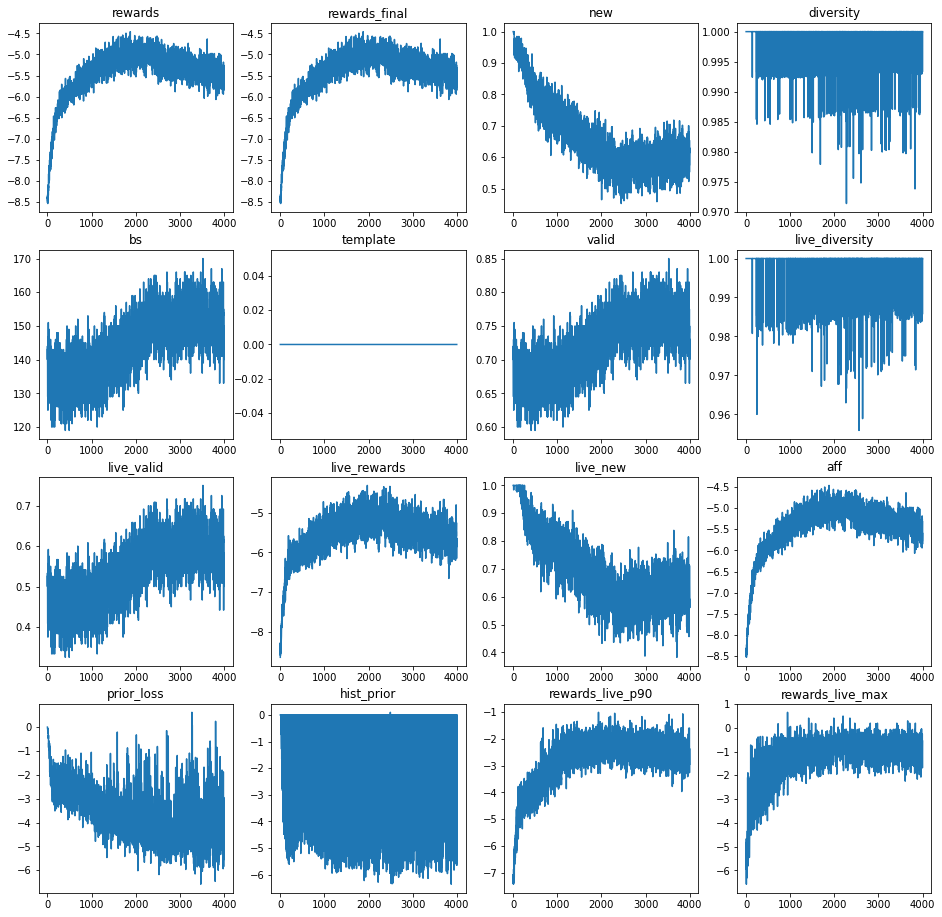

In [36]:
env.log.plot_metrics()

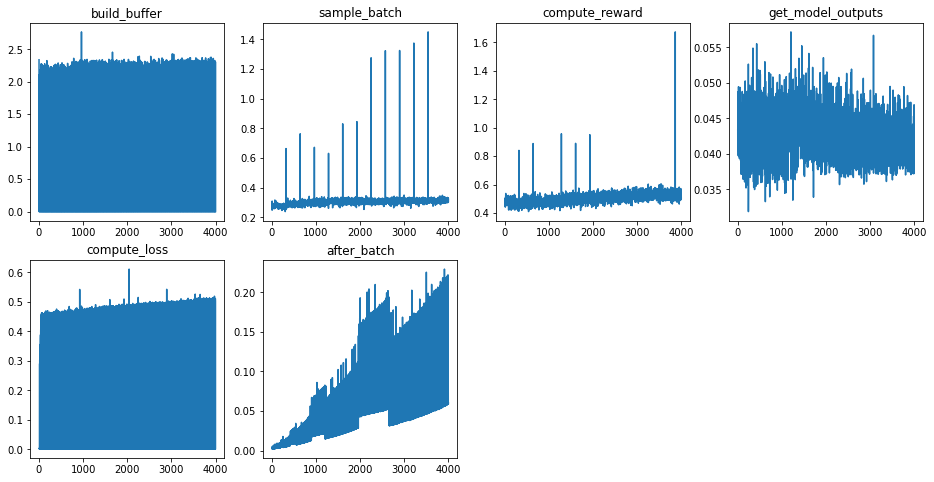

In [37]:
env.log.plot_timelog()

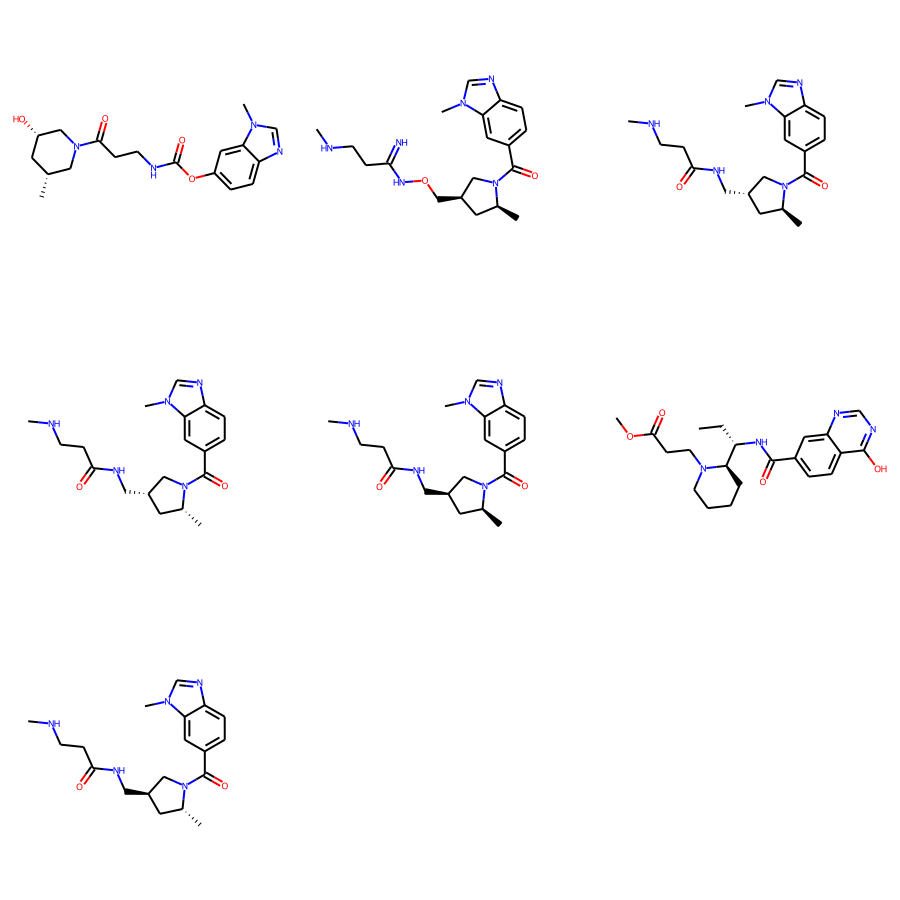

In [41]:
draw_mols(to_mols(env.log.df[env.log.df.aff>0.4].samples.values))

### Conditional LSTM LM Contrastive

In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

# ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
ds = Vec_To_Text_Dataset([('CCC', '')], vocab, partial(failsafe_fp, fp_function=ECFP6))
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [11]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [12]:
agent.update_dataset_from_inputs(temp_df.smiles.values[:1000000])

In [12]:
os.environ['ncpus'] = '10'
agent.train_supervised(500, 1, 5e-5)
os.environ['ncpus'] = '0'

Epoch,Train Loss,Valid Loss,Time
0,0.01700,0.01801,04:23


In [25]:
refresh_global_pool()

In [12]:
gen_bs = 1500

# data_df = next(pd.read_csv('/home/dmai/smiles_datasets/shard_0.csv', chunksize=1000000))
# sampler1 = DatasetSampler(data_df.smiles.values, 2000, 'zinc_data')
sampler1 = DatasetSampler(temp_df.smiles.values[:1000000], 2000, 'zinc_data')
sampler1 = ContrastiveSampler(sampler1, vocab, ds, agent.model, gen_bs, repeats=5)

sampler2 = LogSampler('samples', 'rewards', 50, 95, 500)

samplers = [sampler1, sampler2]

In [13]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)

cbs = [supervised_cb]

In [14]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     ChargeFilter(None, 0)],
                    [], 
                    fail_score=-10., log=False)

sf = FPSimilarity(partial(failsafe_fp, fp_function=ECFP6), tanimoto_rd, 0.2, 0.95, 0.05, -1.)
template_cb = ContrastiveTemplate(sf, max_score=2., template=template, prefilter=True)

In [15]:
contrastive_reward = ContrastiveReward(aff_reward)

In [16]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[contrastive_reward], loss_cbs=[loss],
                 cbs=cbs)

In [17]:
refresh_global_pool()

In [19]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,template_temp,template_sim,valid,aff,PPO
0,0.003,0.003,1.000,1.000,200,0.050,0.000,0.050,1.000,-0.047,0.586
10,-0.095,-0.095,1.000,1.000,200,0.050,0.000,0.050,1.000,-0.145,7.266
20,0.041,0.041,1.000,1.000,200,0.050,0.000,0.050,1.000,-0.009,0.816
30,0.128,0.128,1.000,1.000,200,0.050,0.000,0.050,1.000,0.078,0.539
40,0.196,0.196,1.000,1.000,200,0.050,0.000,0.050,1.000,0.146,3.462
50,0.056,0.056,1.000,1.000,200,0.050,0.000,0.050,1.000,0.006,23.476
60,0.513,0.513,0.840,1.000,200,0.050,0.000,0.050,1.000,0.463,116.467
70,0.474,0.474,0.795,1.000,200,0.050,0.000,0.050,1.000,0.424,4.943
80,0.676,0.676,0.765,1.000,200,0.050,0.000,0.050,1.000,0.626,6.288
90,0.488,0.488,0.795,1.000,200,0.050,0.000,0.050,1.000,0.438,1.657


Epoch,Train Loss,Valid Loss,Time
0,0.23034,0.30096,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.81263,0.28185,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.20567,0.16572,00:05


Epoch,Train Loss,Valid Loss,Time
0,0.20386,0.27478,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.18671,0.16491,00:08


In [78]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,template_temp,template_sim,valid,aff,PPO
1000,0.561,0.561,0.825,1.000,200,0.050,0.000,0.050,1.000,0.511,20.964
1010,0.504,0.504,0.825,1.000,200,0.050,0.000,0.050,1.000,0.454,2.129
1020,0.344,0.344,0.900,1.000,200,0.050,0.000,0.050,1.000,0.294,2.984
1030,0.314,0.314,0.905,1.000,200,0.050,0.000,0.050,1.000,0.264,0.603
1040,0.401,0.401,0.920,1.000,200,0.050,0.000,0.050,1.000,0.351,0.563
1050,0.369,0.369,0.905,1.000,200,0.050,0.000,0.050,1.000,0.319,43.256
1060,0.484,0.484,0.900,1.000,200,0.050,0.000,0.050,1.000,0.434,0.457
1070,0.586,0.586,0.840,1.000,200,0.050,0.000,0.050,1.000,0.536,0.664
1080,0.414,0.414,0.880,1.000,200,0.050,0.000,0.050,1.000,0.364,444.053
1090,0.519,0.519,0.860,1.000,200,0.050,0.000,0.050,1.000,0.469,0.603


Epoch,Train Loss,Valid Loss,Time
0,0.17714,0.18048,00:10


Epoch,Train Loss,Valid Loss,Time
0,0.16624,0.22672,00:12


Epoch,Train Loss,Valid Loss,Time
0,0.66227,0.17894,00:13


Epoch,Train Loss,Valid Loss,Time
0,0.11091,0.24216,00:15


Epoch,Train Loss,Valid Loss,Time
0,0.13235,0.24679,00:17


In [82]:
samples = env.log.df[env.log.df.aff>6.4].samples.values
sources = [i[0] for i in samples]
targets = [i[1] for i in samples]
source_scores = aff_reward.weight*aff_reward._compute_reward(sources)
target_scores = aff_reward.weight*aff_reward._compute_reward(targets)

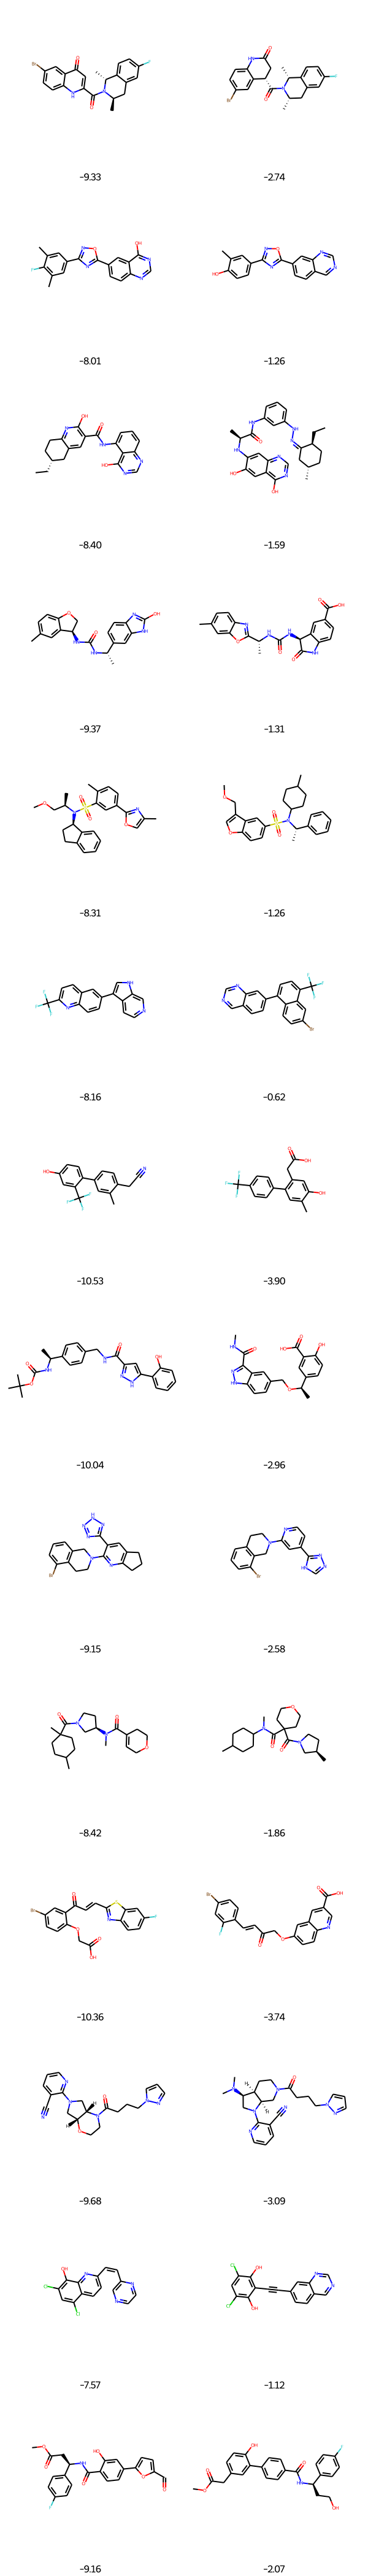

In [83]:
draw_mols(to_mols(flatten_list_of_lists(zip(sources, targets))), mols_per_row=2,
         legends = flatten_list_of_lists(zip([f'{i.item():.2f}' for i in source_scores],
                                        [f'{i.item():.2f}' for i in target_scores])))

In [84]:
samples = temp_df.sample(n=100).smiles.values
sampler1.repeats = 20
new_samples = sampler1.sample_outputs(samples, 90)
sampler1.repeats = 4

In [85]:
source_scores = aff_reward.weight*aff_reward.compute_batched_reward([i[0] for i in new_samples])
target_scores = aff_reward.weight*aff_reward.compute_batched_reward([i[1] for i in new_samples])

In [86]:
(target_scores - source_scores).max()

tensor(5.0927)

In [87]:
pred_df = pd.DataFrame([i[0] for i in new_samples], columns=['source'])
pred_df['target'] = [i[1] for i in new_samples]
pred_df['source_scores'] = source_scores.numpy()
pred_df['target_scores'] = target_scores.numpy()
pred_df['diff'] = pred_df.target_scores - pred_df.source_scores

<AxesSubplot:>

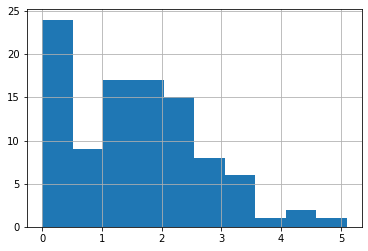

In [88]:
pred_df.groupby('source')['diff'].max().hist()

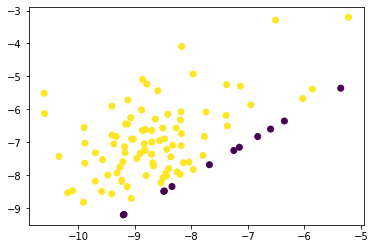

In [96]:
source_vals = pred_df.groupby('source')['source_scores'].max()
target_vals = pred_df.groupby('source')['target_scores'].max()

plt.scatter(source_vals,
            target_vals,
            c=(target_vals>source_vals))

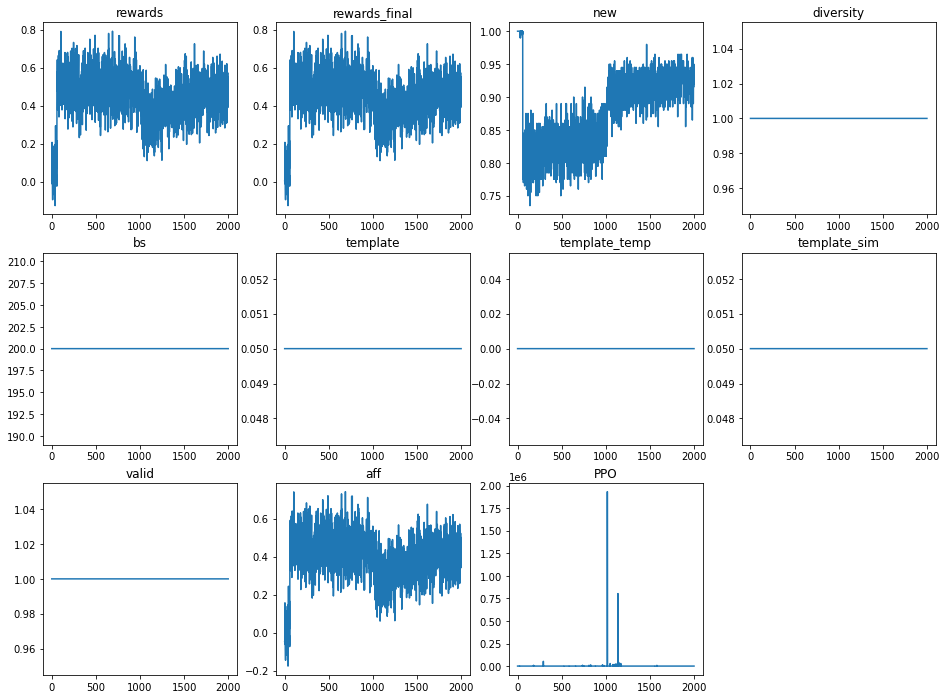

In [97]:
env.log.plot_metrics()

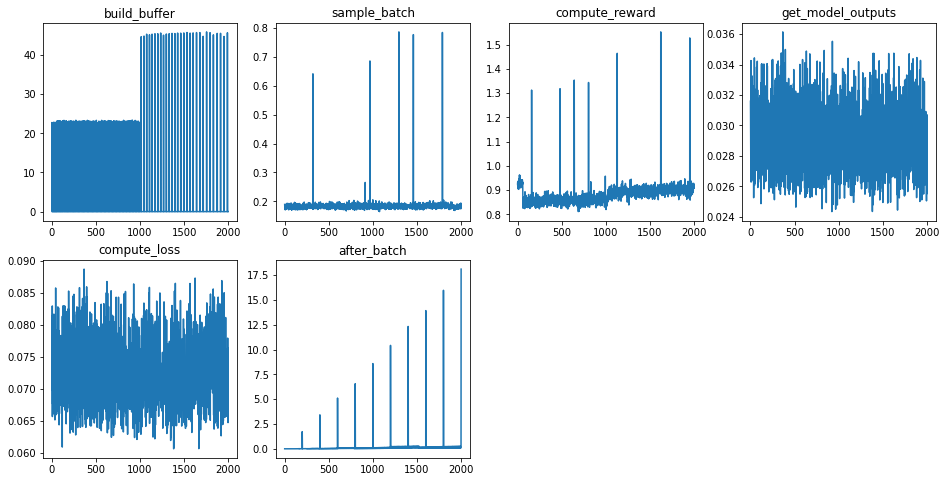

In [98]:
env.log.plot_timelog()

## LSTM R Group

In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_rgroup.pt'))

<All keys matched successfully>

In [11]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [12]:
reference = 'O=C(CCCCCCn1cc(-c2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)nn1)NO'
scaffold = '*c1ccc2ncnc(Nc3cccc(Cl)c3F)c2c1'

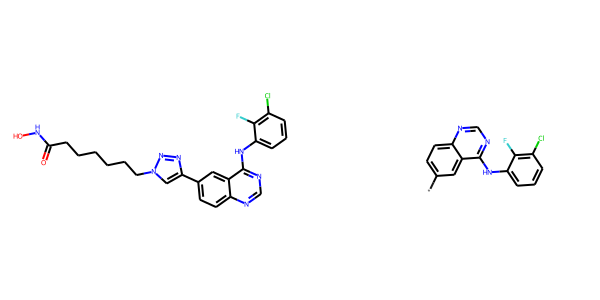

In [13]:
draw_mols(to_mols([reference, scaffold]))

In [14]:
r_template = Template(
                    [MolWtFilter(20, 200),
                     RingFilter(1,2)],
                    [],
                    fail_score=-1, log=False
                    )

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']



full_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 10),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

template = RGroupBlockTemplate(scaffold, r_template, 
                                    full_molecule_template=full_template)

template_cb = TemplateCallback(template, prefilter=True)

In [15]:
# df = pd.read_csv('../../smiles_datasets/single_frags.csv')
# df = df[df.weight<175]

# os.environ['ncpus'] = '64'
# screened = template.recurse_fragments(df.smiles.values)
# os.environ['ncpus'] = '0'

# screened = [i for i in screened if i[2]]

# screened = [i[0] for i in screened]
# screened = [i.replace('[2*:1]', '*') for i in screened]

# screened = list(set(screened))

# df = pd.DataFrame(screened, columns=['smiles'])
# df.to_csv('rgroup_screened.csv', index=False)

In [16]:
df = pd.read_csv('rgroup_screened.csv')
agent.update_dataset_from_inputs(df.smiles.values)
agent.train_supervised(256, 3, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.53633,0.46570,00:44
1,0.49056,0.46008,00:44
2,0.49434,0.45971,00:45


<All keys matched successfully>

In [17]:
refresh_global_pool()

In [18]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.4, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [19]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [20]:
# aff_reward = FunctionReward(r_agent.predict_data, 
#                             'aff', 
#                             weight=-10.,
#                            sample_name='samples_fused')

aff_reward = RewardCallback(reward, 'aff', sample_name='samples_fused')

In [21]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [21]:
%%time
env.fit(200, 45, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-4.927,-4.927,1.000,1.000,154,0.000,0.770,1.000,0.425,-4.685,1.000,-4.927,0.581,-2.609,-1.722
10,-4.927,-4.927,0.987,1.000,149,0.000,0.745,1.000,0.362,-4.891,1.000,-4.927,0.434,-3.431,-2.395
20,-4.756,-4.756,0.903,1.000,154,0.000,0.770,1.000,0.425,-4.842,1.000,-4.756,0.613,-3.211,-2.091
30,-4.518,-4.518,0.877,1.000,155,0.000,0.775,1.000,0.438,-4.955,0.943,-4.518,0.582,-3.549,-1.443
40,-4.544,-4.544,0.854,1.000,144,0.000,0.720,1.000,0.300,-4.576,0.917,-4.544,0.679,-2.613,-1.007
50,-4.548,-4.548,0.892,1.000,148,0.000,0.740,1.000,0.350,-4.916,1.000,-4.548,0.686,-3.210,-2.431
60,-4.609,-4.609,0.874,1.000,151,0.000,0.755,1.000,0.388,-4.714,1.000,-4.609,0.732,-2.494,-1.934
70,-4.581,-4.581,0.919,1.000,149,0.000,0.745,1.000,0.362,-4.665,1.000,-4.581,0.697,-2.475,-1.575
80,-4.539,-4.539,0.866,1.000,157,0.000,0.785,1.000,0.463,-4.920,0.892,-4.539,0.629,-3.363,-1.615
90,-4.493,-4.493,0.873,1.000,150,0.000,0.750,1.000,0.375,-4.867,0.967,-4.493,0.584,-2.805,-1.991


Epoch,Train Loss,Valid Loss,Time
0,0.52001,0.49825,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.44712,0.51555,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.46927,0.38615,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.44630,0.36819,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.44533,0.40879,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.41333,0.40719,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.38425,0.39755,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.42140,0.43978,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.38829,0.40031,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.39339,0.32003,00:00


CPU times: user 5h 47min 37s, sys: 6min 34s, total: 5h 54min 12s
Wall time: 18min 4s


In [25]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)

avg_reward = np.array(env.log.metrics['rewards'][-20:]).mean()
subset = log_df[(log_df.rewards>avg_reward) & (log_df.template>-5)]
print(subset.shape)

agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_rgroup.pt'))

agent.update_dataset_from_inputs(subset.samples.values)

agent.train_supervised(128, 4, 5e-5)

agent.base_model.load_state_dict(agent.model.state_dict())

(6271, 8)


Epoch,Train Loss,Valid Loss,Time
0,0.61245,0.57613,00:01
1,0.50604,0.48511,00:01
2,0.42919,0.45100,00:01
3,0.40177,0.44772,00:01


<All keys matched successfully>

In [26]:
%%time
env.fit(200, 45, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
2000,-1.889,-1.889,0.220,0.988,168,0.000,0.840,1.000,0.600,-2.281,0.417,-1.889,0.575,-0.853,-0.328
2010,-2.670,-2.670,0.448,1.000,163,0.000,0.815,1.000,0.537,-2.614,0.442,-2.670,0.773,-0.732,-0.199
2020,-3.032,-3.032,0.509,1.000,165,0.000,0.825,1.000,0.562,-3.629,0.600,-3.032,0.766,-1.357,-1.129
2030,-2.757,-2.757,0.440,1.000,168,0.000,0.840,1.000,0.600,-3.105,0.479,-2.757,0.647,-1.539,-0.639
2040,-2.543,-2.543,0.417,1.000,163,0.000,0.815,1.000,0.537,-2.763,0.488,-2.543,0.599,-1.069,-0.600
2050,-2.941,-2.941,0.452,1.000,166,0.000,0.830,1.000,0.575,-2.931,0.326,-2.941,0.702,-0.771,0.150
2060,-2.783,-2.783,0.451,0.994,164,0.000,0.820,0.977,0.550,-2.600,0.364,-2.783,0.542,-0.697,-0.039
2070,-2.628,-2.628,0.399,1.000,173,0.000,0.865,1.000,0.662,-2.560,0.340,-2.628,0.647,-0.786,-0.102
2080,-2.506,-2.506,0.287,0.988,167,0.000,0.835,0.957,0.588,-2.422,0.298,-2.506,0.546,-0.490,-0.076
2090,-2.773,-2.773,0.479,0.994,167,0.000,0.835,1.000,0.588,-2.932,0.468,-2.773,0.586,-0.636,-0.341


Epoch,Train Loss,Valid Loss,Time
0,0.40305,0.35554,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.37873,0.39819,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.44164,0.43442,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.35141,0.37635,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.37136,0.37592,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.37396,0.37004,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.36927,0.36659,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.34855,0.37132,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.39930,0.35440,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.32633,0.31712,00:01


CPU times: user 6h 27min 53s, sys: 7min 16s, total: 6h 35min 9s
Wall time: 17min 49s


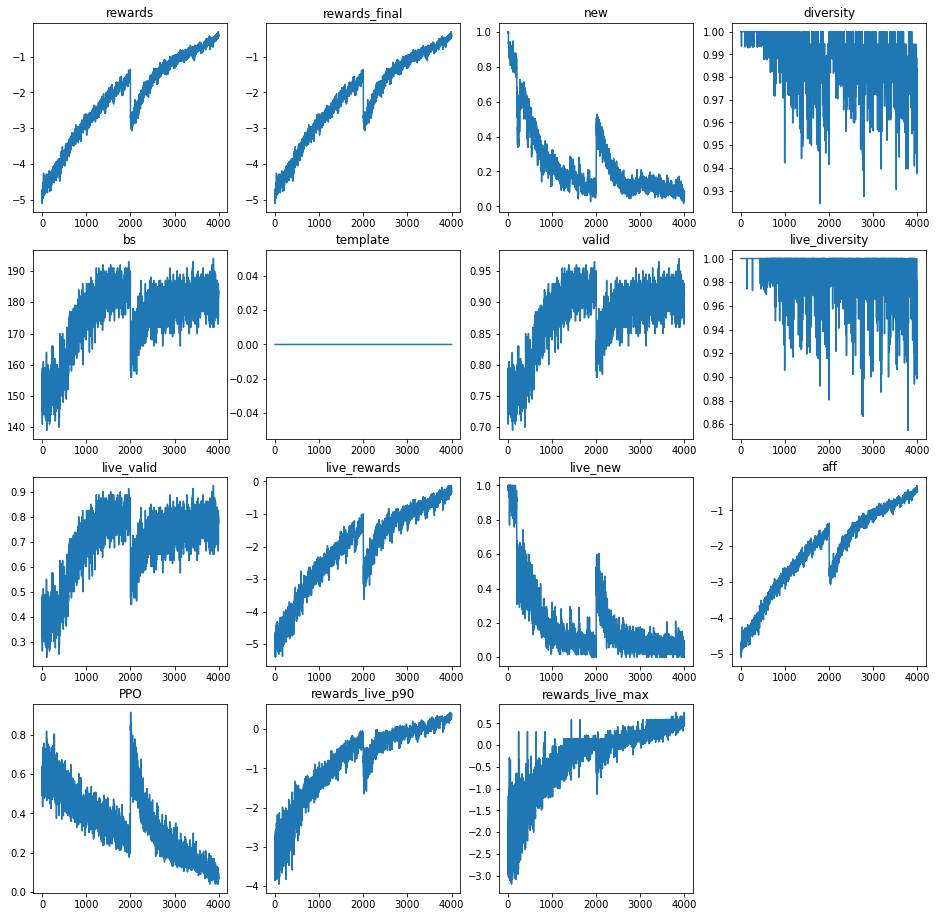

In [27]:
env.log.plot_metrics()

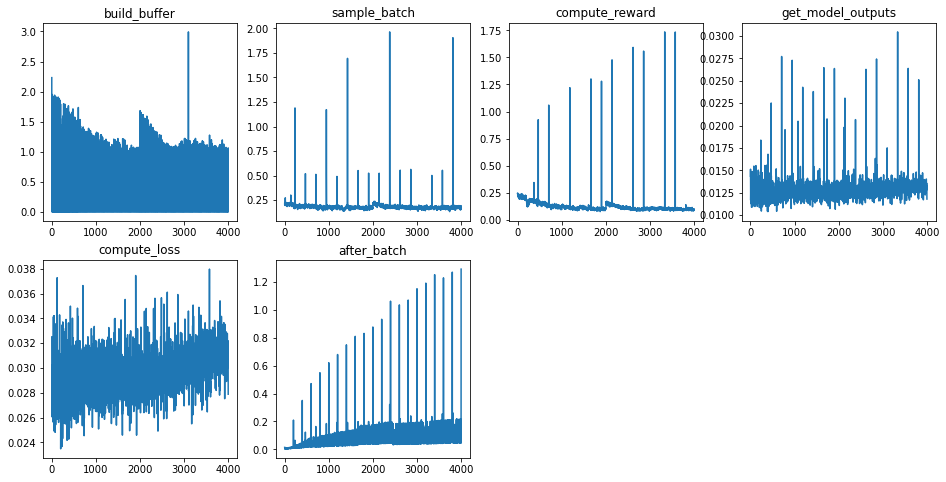

In [28]:
env.log.plot_timelog()

In [29]:
ref_reward = aff_reward._compute_reward([reference]).item()
ref_reward

-0.036748893558979034

In [30]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)
log_df[log_df.aff>ref_reward]

,samples,sources,rewards,rewards_final,template,samples_fused,aff,PPO
29096,*C1CCC(NC(=O)C=CCO)C1,live,0.311801,0.311801,0.0,O=C(C=CCO)NC1CCC(c2ccc3ncnc(Nc4cccc(Cl)c4F)c3c...,0.311801,3.999276
71311,*Cc1ncnc(C(N)=O)c1Cl,live,-0.030829,-0.030829,0.0,NC(=O)c1ncnc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c1Cl,-0.030829,0.549373
71556,*Cc1cnc(CO)c(C(N)=O)n1,live,0.058147,0.058147,0.0,NC(=O)c1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)cnc1CO,0.058147,0.459932
81050,*Cc1n[nH]nc1C(N)=O,live,-0.006915,-0.006915,0.0,NC(=O)c1n[nH]nc1Cc1ccc2ncnc(Nc3cccc(Cl)c3F)c2c1,-0.006915,0.073979
82465,*Cc1ncnc(C(N)=O)c1CO,live,0.147283,0.147283,0.0,NC(=O)c1ncnc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c1CO,0.147283,-0.240205
...,...,...,...,...,...,...,...,...
162988,*Cc1nc(C(N)=O)ncc1C=CC[CH-],buffer,0.035154,0.035154,0.0,[CH-]CC=Cc1cnc(C(N)=O)nc1Cc1ccc2ncnc(Nc3cccc(C...,0.035154,-0.663334
162990,*Cc1ncn2c1COC2C(=O)C[N],buffer,0.302146,0.302146,0.0,[N]CC(=O)C1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4...,0.302146,-0.984495
162991,*Cc1ncn2c1COC2CC([CH-])N,buffer,-0.002653,-0.002653,0.0,[CH-]C(N)CC1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c...,-0.002653,-0.592737
163001,*Cc1nn(CO)c2c1C(O)CC2C=[N-],live,0.395968,0.395968,0.0,[N-]=CC1CC(O)c2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4...,0.395968,-1.110828


In [33]:
log_df[log_df.aff>0.6]

,samples,sources,rewards,rewards_final,template,samples_fused,aff,PPO
158239,*Cc1ncn2c1COC2CC=NO,live,0.665176,0.665176,0.0,ON=CCC1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)n...,0.665176,-1.451069
158901,*Cc1ncn2c1COC2COC=N,live,0.614920,0.614920,0.0,N=COCC1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)n...,0.614920,-1.187806
159484,*Cc1ncn2c1COC2CCC(=O)[O-],buffer,0.766103,0.766103,0.0,O=C([O-])CCC1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)...,0.766103,-1.504961
159717,*Cc1ncn2c1COC2C(N)C=N,live,0.756263,0.756263,0.0,N=CC(N)C1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3...,0.756263,-1.346361
160334,*Cc1ncn2c1C(O)C(CF)CC2N,live,0.647299,0.647299,0.0,NC1CC(CF)C(O)c2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4...,0.647299,-1.153153
161133,*Cc1ncn2c1COC2CO[NH],buffer,0.623242,0.623242,0.0,[NH]OCC1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)...,0.623242,-1.205120
161538,*Cc1ncn2c1[SH](N)CCC2N,buffer,0.690916,0.690916,0.0,NC1CC[SH](N)c2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c...,0.690916,-0.716793
161649,*Cc1ncn2c1CC(O)C2[N-]N,live,0.625979,0.625979,0.0,N[N-]C1C(O)Cc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c...,0.625979,-1.245999
162537,*Cc1ncn2c1COC2C(N)C=C[N-],buffer,0.640307,0.640307,0.0,[N-]C=CC(N)C1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)...,0.640307,-1.412774
162689,*Cc1ncn2c1CCC2OCOO,live,0.641512,0.641512,0.0,OOCOC1CCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)ncn21,0.641512,-1.229429


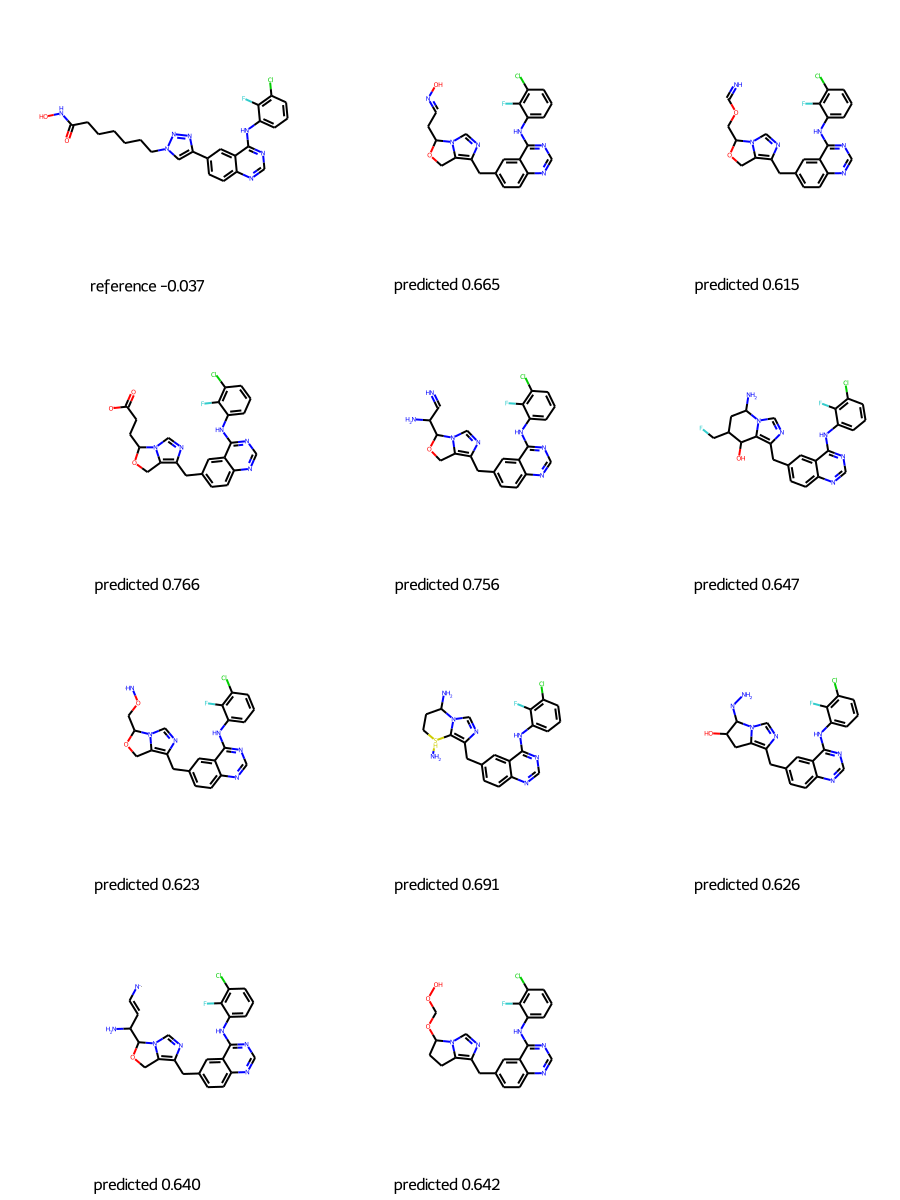

In [34]:
predicted = list(log_df[log_df.aff>0.6].samples_fused.values)
affinities = log_df[log_df.aff>0.6].aff.values
draw_mols(to_mols([reference]+ predicted),
         legends=[f'reference {ref_reward:.3f}']+[f'predicted {affinities[i]:.3f}' for i in range(len(predicted))])

### LSTM LM Beam Search

In [5]:
# os.environ['use_cuda'] = 'cpu'

In [80]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

<All keys matched successfully>

In [81]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [82]:
agent.update_dataset_from_inputs(df[df.value<5].smiles.values)
agent.train_supervised(32, 4, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.59993,0.44867,00:02
1,0.29946,0.33333,00:02
2,0.28753,0.30202,00:02
3,0.28034,0.29855,00:02


In [83]:
agent.update_dataset_from_inputs(df[df.value<0].smiles.values)
agent.train_supervised(32, 3, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.26167,0.22664,00:00
1,0.26387,0.22383,00:00
2,0.22908,0.22306,00:00


In [84]:
agent.update_dataset_from_inputs(df[df.value<-2].smiles.values)
agent.train_supervised(32, 3, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.28959,0.41462,00:00
1,0.25885,0.39703,00:00
2,0.24501,0.39703,00:00


In [93]:
k = len(vocab.itos)
beam_size = 300
sl = 90
hiddens = None
temperature = 1.
select_distinct = False

seed_sequence = ''
seed_tokens = vocab.tokenize(seed_sequence)[:-1]

seed_ints = torch.tensor(vocab.numericalize(seed_tokens)).long().unsqueeze(0)

current_device = next(model.parameters()).device

preds = seed_ints.repeat(k,1)
preds = to_device(preds)
idxs = preds[:,-1].unsqueeze(-1)

lps = idxs.new_zeros((k, 1)).float()

with torch.no_grad():
    for i in range(sl):
        x, hiddens, encoded = model._forward(idxs, hiddens)
        x.div_(temperature)
        
        log_probs = F.log_softmax(x, -1)
#         log_probs = log_probs.squeeze(1)
#         indices = torch.multinomial(log_probs.exp(), k)
#         values = torch.gather(log_probs, 1, indices).unsqueeze(1)
        values, indices = log_probs.topk(k, dim=-1)
        
        lps = torch.cat([lps.unsqueeze(-1).repeat(1,1,values.shape[-1]), -values], 1)
        current_sl = lps.shape[1]
        lps = lps.permute(0,2,1).reshape(-1,current_sl)
        
        preds = torch.cat([preds[:,None].expand(preds.size(0), k , preds.size(1)),
                indices.squeeze(1)[:,:,None].expand(preds.size(0), k, 1),], dim=2)
        
        preds = preds.view(-1, preds.size(2))
        
        if select_distinct:
            pred_strs = ['_'.join([str(j) for j in i]) for i in preds.detach().cpu().numpy()]
            pred_strs = [i.split('_2_')[0] for i in pred_strs]
            unique_idxs = (~pd.Series(pred_strs).duplicated()).values
#             unique_idxs = (~pd.Series(agent.reconstruct(preds)).duplicated()).values
#             unique_idxs = (~pd.Series([vocab.reconstruct(i) for i in preds]).duplicated()).values
#             unique_idxs = torch.unique(torch.unique(preds, dim=0, return_inverse=True)[1])
            preds = preds[unique_idxs]
            lps = lps[unique_idxs]
        
        scores = lps.sum(-1)
        indices_idx = torch.arange(0,preds.size(0))[:,None].expand(preds.size(0), k).contiguous().view(-1)
        sort_idx = scores.argsort()[:beam_size]

        preds = preds[sort_idx]
        lps = lps[sort_idx]
        
        idxs = preds[:,-1].unsqueeze(-1)
        hiddens = [(i[0][:, indices_idx[sort_idx], :], i[1][:, indices_idx[sort_idx], :]) for i in hiddens]
        
        if (preds[:,-1]==vocab.stoi['pad']).all():
            break

In [94]:
len(set(agent.reconstruct(preds)))

7

In [95]:
np.array([i is not None for i in to_mols(list(set(agent.reconstruct(preds))))]).mean()

1.0

In [96]:
smiles = list(set(agent.reconstruct(preds)))

In [97]:
gen_preds = -10*aff_reward._compute_reward(smiles).detach().cpu().numpy()

In [100]:
real_preds = -10*aff_reward._compute_reward(list(df[df.value<0].smiles.values)).detach().cpu().numpy()

(array([0.5298337 , 0.        , 0.        , 0.        , 0.        ,
        1.05966694, 0.        , 0.5298337 , 0.        , 1.58950076]),
 array([-3.195878  , -2.9262516 , -2.656625  , -2.3869987 , -2.1173723 ,
        -1.8477458 , -1.5781193 , -1.3084928 , -1.0388664 , -0.7692399 ,
        -0.49961346], dtype=float32),
 <BarContainer object of 10 artists>)

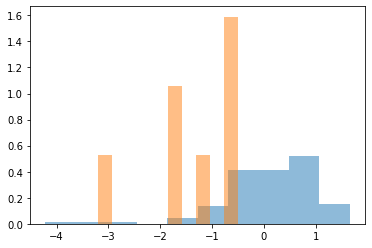

In [101]:
plt.hist(real_preds, density=True, alpha=0.5)
plt.hist(gen_preds, density=True, alpha=0.5)

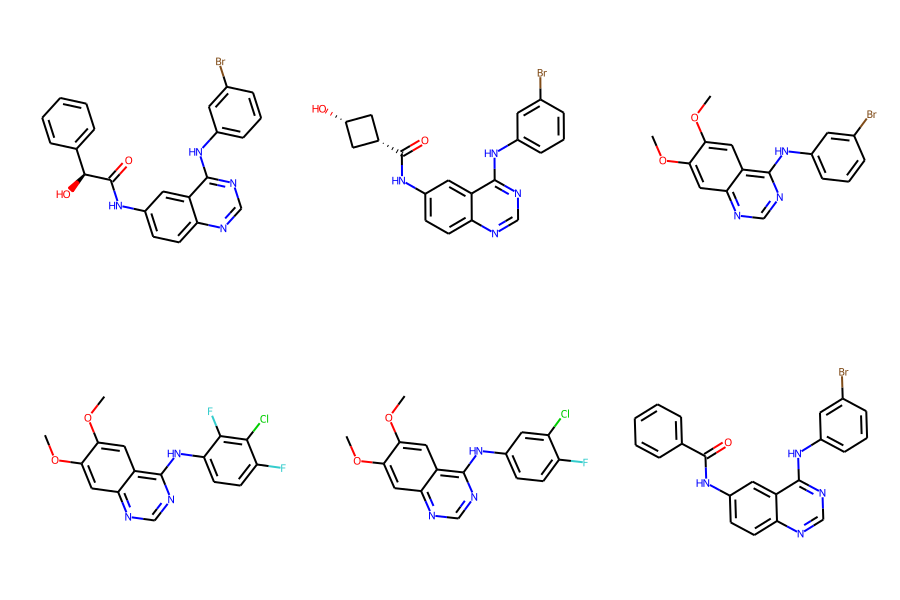

In [92]:
draw_mols(to_mols(smiles))